**📦 Step 1: Import Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_palette("husl")
print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


**🔍 Step 2: Load Data & Prepare Brand Analysis**

In [2]:
# Load cleaned data
drive.mount('/content/drive')

# Set working directory
working_dir = '/content/drive/MyDrive/Colab Notebooks/AI-Applications-Portfolio/amazon-sentiment-analysis'
file_path = f"{working_dir}/cleaned_amazon_data.csv"

df = pd.read_csv(file_path)

# Calculate brand metrics
brand_analysis = df.groupby('brand').agg({
    'price': ['mean', 'median', 'count', 'std'],
    'rating': 'mean',
    'review_count': 'sum'
}).round(2)

brand_analysis.columns = ['avg_price', 'median_price', 'product_count', 'price_std', 'avg_rating', 'total_reviews']
brand_analysis = brand_analysis[brand_analysis['product_count'] >= 3]  # Minimum 3 products per brand

print("📊 Brand analysis dataset prepared!")
print(f"📈 Total brands with ≥3 products: {len(brand_analysis)}")

Mounted at /content/drive
📊 Brand analysis dataset prepared!
📈 Total brands with ≥3 products: 5


**💰 Step 3: Brand Price Positioning Analysis**

In [3]:
def analyze_price_positioning(brand_df):
    # Classify brands by price segment
    price_quantiles = brand_df['avg_price'].quantile([0.33, 0.66])
    low_threshold = price_quantiles.iloc[0]
    high_threshold = price_quantiles.iloc[1]

    brand_df['price_segment'] = pd.cut(brand_df['avg_price'],
                                      bins=[0, low_threshold, high_threshold, float('inf')],
                                      labels=['Budget', 'Mid-Range', 'Premium'])

    # Classify by value proposition
    brand_df['value_score'] = (brand_df['avg_rating'] * brand_df['total_reviews']) / brand_df['avg_price']
    brand_df['value_segment'] = pd.qcut(brand_df['value_score'], 3, labels=['Low Value', 'Medium Value', 'High Value'])

    return brand_df, low_threshold, high_threshold

brand_analysis, low_thresh, high_thresh = analyze_price_positioning(brand_analysis)

print("🎯 Price Segmentation Thresholds:")
print(f"💰 Budget: < ${low_thresh:.2f}")
print(f"📱 Mid-Range: ${low_thresh:.2f} - ${high_thresh:.2f}")
print(f"🏆 Premium: > ${high_thresh:.2f}")

🎯 Price Segmentation Thresholds:
💰 Budget: < $18.11
📱 Mid-Range: $18.11 - $48.59
🏆 Premium: > $48.59


**📊 Step 4: Price Segment Analysis**

In [5]:
segment_analysis = brand_analysis.reset_index().groupby('price_segment').agg({
    'avg_price': 'mean',
    'avg_rating': 'mean',
    'product_count': 'sum',
    'total_reviews': 'sum',
    'brand': 'count'
}).round(2)

segment_analysis.columns = ['avg_segment_price', 'avg_rating', 'total_products', 'total_reviews', 'number_of_brands']

print("📈 Price Segment Performance:")
print(segment_analysis)

# Calculate market share
segment_analysis['market_share'] = (segment_analysis['total_products'] / segment_analysis['total_products'].sum() * 100).round(1)
print(f"\n📊 Market Share by Segment:")
print(segment_analysis[['market_share']])

📈 Price Segment Performance:
               avg_segment_price  avg_rating  total_products  total_reviews  \
price_segment                                                                 
Budget                     10.59        4.52               7        50455.0   
Mid-Range                  31.40        4.57               3         1659.0   
Premium                    59.95        4.61               9       113398.0   

               number_of_brands  
price_segment                    
Budget                        2  
Mid-Range                     1  
Premium                       2  

📊 Market Share by Segment:
               market_share
price_segment              
Budget                 36.8
Mid-Range              15.8
Premium                47.4


**🎨 Step 5: Visualization - Price vs Value Matrix**

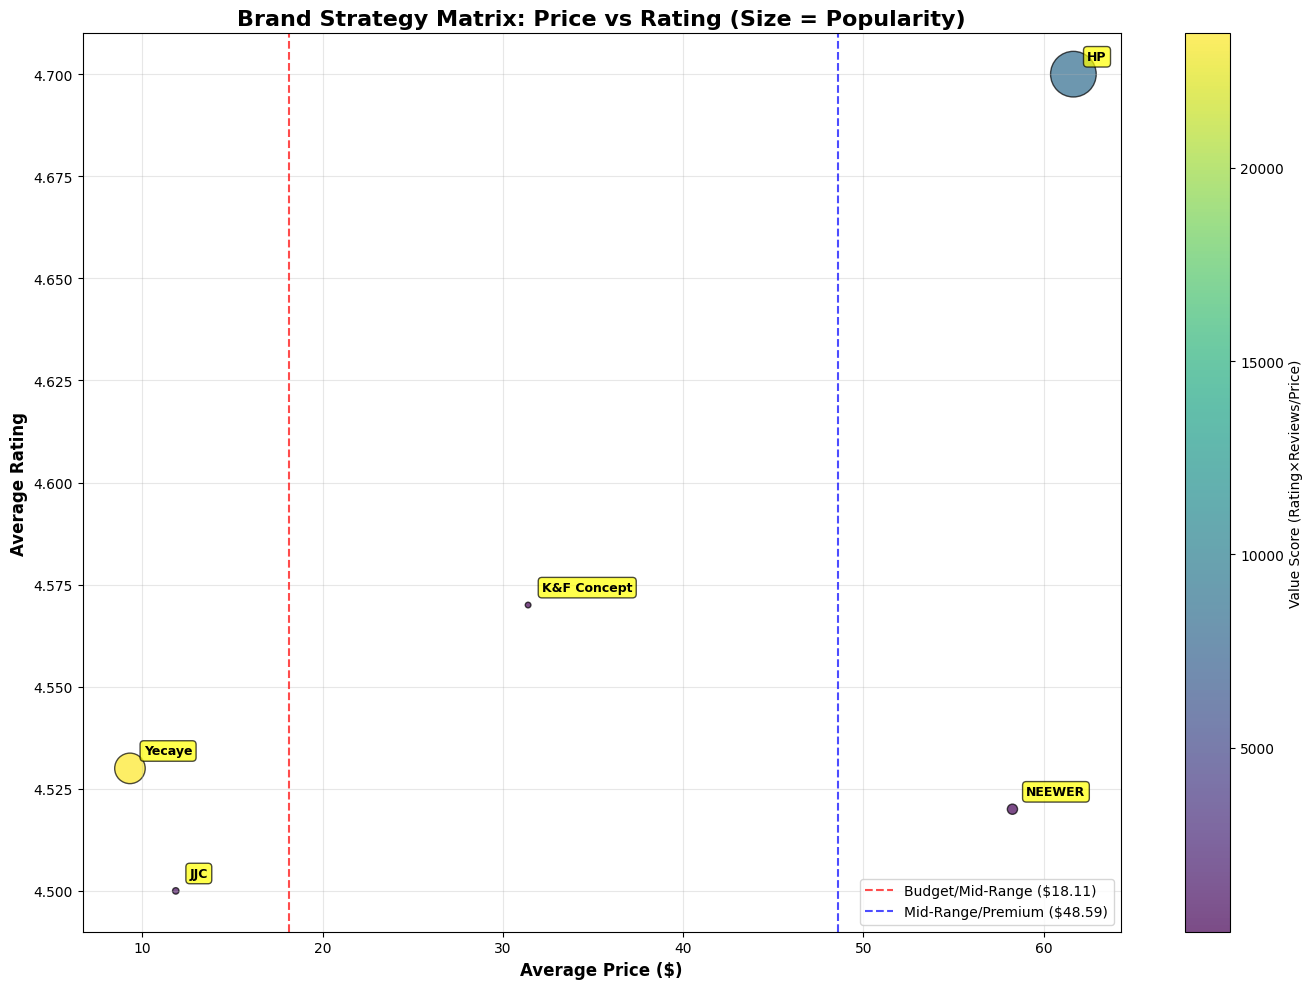

In [6]:
plt.figure(figsize=(14, 10))

# Create scatter plot with segments
scatter = plt.scatter(brand_analysis['avg_price'], brand_analysis['avg_rating'],
                     c=brand_analysis['value_score'],
                     s=brand_analysis['total_reviews']/100,
                     cmap='viridis', alpha=0.7, edgecolors='black')

# Add segment boundaries
plt.axvline(x=low_thresh, color='red', linestyle='--', alpha=0.7, label=f'Budget/Mid-Range (${low_thresh:.2f})')
plt.axvline(x=high_thresh, color='blue', linestyle='--', alpha=0.7, label=f'Mid-Range/Premium (${high_thresh:.2f})')

plt.colorbar(scatter, label='Value Score (Rating×Reviews/Price)')
plt.xlabel('Average Price ($)', fontsize=12, fontweight='bold')
plt.ylabel('Average Rating', fontsize=12, fontweight='bold')
plt.title('Brand Strategy Matrix: Price vs Rating (Size = Popularity)', fontsize=16, fontweight='bold')

# Annotate top brands
top_brands = brand_analysis.nlargest(10, 'value_score')
for i, (brand, row) in enumerate(top_brands.iterrows()):
    plt.annotate(brand, (row['avg_price'], row['avg_rating']),
                xytext=(10, 10), textcoords='offset points',
                fontsize=9, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(f'{working_dir}/brand_strategy_matrix.png')
plt.show()

**📋 Step 6: Strategic Brand Categories**

In [7]:
def categorize_brands(brand_df):
    conditions = [
        (brand_df['avg_price'] > high_thresh) & (brand_df['avg_rating'] >= 4.0),
        (brand_df['avg_price'] > high_thresh) & (brand_df['avg_rating'] < 4.0),
        (brand_df['avg_price'] <= high_thresh) & (brand_df['avg_rating'] >= 4.0),
        (brand_df['avg_price'] <= high_thresh) & (brand_df['avg_rating'] < 4.0)
    ]

    choices = ['Premium Quality', 'Overpriced', 'Value Leaders', 'Budget Options']

    brand_df['strategy_category'] = np.select(conditions, choices, default='Other')
    return brand_df

brand_analysis = categorize_brands(brand_analysis)

print("🎯 Strategic Brand Categories:")
strategy_counts = brand_analysis['strategy_category'].value_counts()
print(strategy_counts)

🎯 Strategic Brand Categories:
strategy_category
Value Leaders      3
Premium Quality    2
Name: count, dtype: int64


**📊 Step 7: Detailed Strategy Analysis**

In [10]:
strategy_analysis = brand_analysis.reset_index().groupby('strategy_category').agg({
    'avg_price': 'mean',
    'avg_rating': 'mean',
    'value_score': 'mean',
    'brand': 'count'
}).round(2)

print("📈 Performance by Strategy Category:")
print(strategy_analysis)

# Identify specific brands in each category
print("\n🔍 Top Brands in Each Strategy:")
for category in strategy_analysis.index:
    category_brands = brand_analysis[brand_analysis['strategy_category'] == category]
    top_3 = category_brands.nlargest(3, 'value_score')
    print(f"\n{category}:")
    for brand, row in top_3.iterrows():
        print(f"  - {brand}: ${row['avg_price']} | {row['avg_rating']}⭐ | Value: {row['value_score']:.2f}")

📈 Performance by Strategy Category:
                   avg_price  avg_rating  value_score  brand
strategy_category                                           
Premium Quality        59.95        4.61      4326.84      2
Value Leaders          17.53        4.53      8178.89      3

🔍 Top Brands in Each Strategy:

Premium Quality:
  - HP: $61.64 | 4.7⭐ | Value: 8236.06
  - NEEWER: $58.26 | 4.52⭐ | Value: 417.63

Value Leaders:
  - Yecaye: $9.32 | 4.53⭐ | Value: 23482.12
  - JJC: $11.86 | 4.5⭐ | Value: 813.11
  - K&F Concept: $31.4 | 4.57⭐ | Value: 241.45


**💡 Step 8: Strategic Recommendations**

In [11]:
print("🎯 STRATEGIC RECOMMENDATIONS FOR BRANDS:")
print("=" * 50)

# Recommendation 1: Premium Quality Brands
premium_brands = brand_analysis[brand_analysis['strategy_category'] == 'Premium Quality']
if not premium_brands.empty:
    print(f"\n1. 🏆 PREMIUM QUALITY LEADERS ({len(premium_brands)} brands):")
    print("   Maintain high quality and justify premium pricing with excellence")
    print(f"   Example: {premium_brands.index[0]} (${premium_brands['avg_price'].iloc[0]:.2f}, {premium_brands['avg_rating'].iloc[0]}⭐)")

# Recommendation 2: Value Leaders
value_brands = brand_analysis[brand_analysis['strategy_category'] == 'Value Leaders']
if not value_brands.empty:
    print(f"\n2. 💎 VALUE LEADERS ({len(value_brands)} brands):")
    print("   Expand market share with competitive pricing and high quality")
    print(f"   Example: {value_brands.index[0]} (${value_brands['avg_price'].iloc[0]:.2f}, {value_brands['avg_rating'].iloc[0]}⭐)")

# Recommendation 3: Overpriced Brands
overpriced = brand_analysis[brand_analysis['strategy_category'] == 'Overpriced']
if not overpriced.empty:
    print(f"\n3. ⚠️  OVERPRICED BRANDS ({len(overpriced)} brands):")
    print("   Either improve quality or reduce prices to match value proposition")
    print(f"   Example: {overpriced.index[0]} (${overpriced['avg_price'].iloc[0]:.2f}, {overpriced['avg_rating'].iloc[0]}⭐)")

# Recommendation 4: Budget Options
budget = brand_analysis[brand_analysis['strategy_category'] == 'Budget Options']
if not budget.empty:
    print(f"\n4. 📉 BUDGET OPTIONS ({len(budget)} brands):")
    print("   Consider slight price increases with quality improvements")
    print(f"   Example: {budget.index[0]} (${budget['avg_price'].iloc[0]:.2f}, {budget['avg_rating'].iloc[0]}⭐)")

print(f"\n✅ Total brands analyzed: {len(brand_analysis)}")

🎯 STRATEGIC RECOMMENDATIONS FOR BRANDS:

1. 🏆 PREMIUM QUALITY LEADERS (2 brands):
   Maintain high quality and justify premium pricing with excellence
   Example: HP ($61.64, 4.7⭐)

2. 💎 VALUE LEADERS (3 brands):
   Expand market share with competitive pricing and high quality
   Example: JJC ($11.86, 4.5⭐)

✅ Total brands analyzed: 5


**💾 Step 9: Save Strategic Analysis**

In [12]:
brand_analysis.to_csv(f'/{working_dir}/brand_strategy_analysis.csv')
print("✅ Brand strategy analysis saved successfully!")
print("🎯 Next step: Use these insights for product positioning and pricing decisions!")

✅ Brand strategy analysis saved successfully!
🎯 Next step: Use these insights for product positioning and pricing decisions!
